# Quantization

- Qunatization: It helps reduce the memory overhead of a model and enables running inference with larger LLMs.
- FP16: Standard and BF16: More recenet Brain Float
- BF16: It has more range but less accurate compared to FP16
- Quantization: Interested in more how we can compress more data and decompress later while inference. 

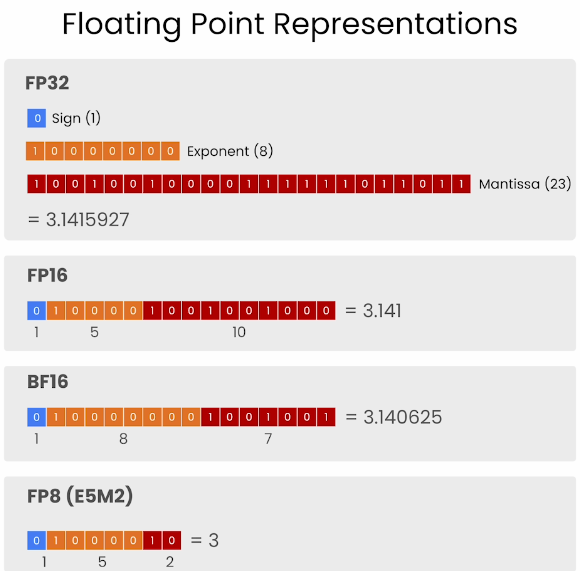

In [2]:
import copy
import matplotlib.pyplot as plt
import numpy as np
import random
import time
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
from transformers.models.gpt2.modeling_gpt2 import GPT2Model

model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

# Define PAD Token = EOS Token = 50256
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = model.config.eos_token_id

# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [3]:
# fix dtype post quantization to "pretend" to be fp32
def get_float32_dtype(self):
    return torch.float32
GPT2Model.dtype = property(get_float32_dtype)

In [4]:
model.get_memory_footprint()

510342192

model has 510 mbs memory

### Quantization and Dequantization function 

In [5]:
def quantize(t):
    # obtain range of values in the tensor to map between 0 and 255
    min_val, max_val = t.min(), t.max()

    # determine the "zero-point", or value in the tensor to map to 0
    scale = (max_val - min_val) / 255
    zero_point = min_val

    # quantize and clamp to ensure we're in [0, 255]
    t_quant = (t - zero_point) / scale
    t_quant = torch.clamp(t_quant, min=0, max=255)

    # keep track of scale and zero_point for reversing quantization
    state = (scale, zero_point)

    # cast to uint8 and return
    t_quant = t_quant.type(torch.uint8)
    return t_quant, state

In [6]:
t = model.transformer.h[0].attn.c_attn.weight.data
print(t, t.shape)

t_q, state = quantize(t)
print(t_q, t_q.min(), t_q.max())

tensor([[-0.4738, -0.2614, -0.0978,  ...,  0.0513, -0.0584,  0.0250],
        [ 0.0874,  0.1473,  0.2387,  ..., -0.0525, -0.0113, -0.0156],
        [ 0.0039,  0.0695,  0.3668,  ...,  0.1143,  0.0363, -0.0318],
        ...,
        [-0.2592, -0.0164,  0.1991,  ...,  0.0095, -0.0516,  0.0319],
        [ 0.1517,  0.2170,  0.1043,  ...,  0.0293, -0.0429, -0.0475],
        [-0.4100, -0.1924, -0.2400,  ..., -0.0046,  0.0070,  0.0198]]) torch.Size([768, 2304])
tensor([[107, 116, 124,  ..., 130, 125, 129],
        [132, 135, 139,  ..., 126, 128, 127],
        [128, 131, 145,  ..., 133, 130, 127],
        ...,
        [116, 127, 137,  ..., 129, 126, 130],
        [135, 138, 133,  ..., 129, 126, 126],
        [110, 119, 117,  ..., 128, 128, 129]], dtype=torch.uint8) tensor(0, dtype=torch.uint8) tensor(255, dtype=torch.uint8)


0 to 255 range of values

In [7]:
def dequantize(t, state):
    scale, zero_point = state
    return t.to(torch.float32) * scale + zero_point

t_rev = dequantize(t_q, state)
print(t_rev)

tensor([[-0.4774, -0.2783, -0.1014,  ...,  0.0313, -0.0793,  0.0092],
        [ 0.0755,  0.1419,  0.2303,  ..., -0.0572, -0.0129, -0.0351],
        [-0.0129,  0.0534,  0.3630,  ...,  0.0976,  0.0313, -0.0351],
        ...,
        [-0.2783, -0.0351,  0.1861,  ...,  0.0092, -0.0572,  0.0313],
        [ 0.1419,  0.2082,  0.0976,  ...,  0.0092, -0.0572, -0.0572],
        [-0.4110, -0.2120, -0.2562,  ..., -0.0129, -0.0129,  0.0092]])


Reconstruction errors

In [8]:
torch.abs(t - t_rev)

tensor([[0.0035, 0.0170, 0.0036,  ..., 0.0200, 0.0209, 0.0158],
        [0.0119, 0.0055, 0.0084,  ..., 0.0046, 0.0017, 0.0195],
        [0.0168, 0.0161, 0.0038,  ..., 0.0167, 0.0050, 0.0032],
        ...,
        [0.0191, 0.0187, 0.0131,  ..., 0.0004, 0.0056, 0.0006],
        [0.0098, 0.0088, 0.0067,  ..., 0.0202, 0.0143, 0.0097],
        [0.0010, 0.0196, 0.0162,  ..., 0.0084, 0.0199, 0.0107]])

### Helper functions

In [18]:
def init_batch(tokenizer, requests):
    prompts = [r[0] for r in requests]
    inputs = tokenizer(prompts, padding=True, return_tensors="pt")
    
    attention_mask = inputs["attention_mask"]
    position_ids = attention_mask.long().cumsum(-1) - 1
    position_ids.masked_fill_(attention_mask == 0, 1)
    
    return {
        "position_ids": position_ids,
        "responses": copy.copy(prompts),
        "tokens_remaining": [r[1] for r in requests],
        **inputs
    }

def generate_batch_tokens_with_past(model, inputs):
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    last_logits = logits[:, -1, :]
    next_token_ids = last_logits.argmax(dim=1)
    return next_token_ids, outputs.past_key_values


def generate_next_token(model, tokenizer, batch):
    inputs = copy.copy(batch)
    inputs.pop("responses")
    inputs.pop("tokens_remaining")
    
    next_token_ids, past_key_values = generate_batch_tokens_with_past(model, inputs)
    next_tokens = tokenizer.batch_decode(next_token_ids)
    return get_next_inputs(batch, next_token_ids, past_key_values, next_tokens)

def filter_batch(batch):
    # mark all rows with 0 tokens remaining for removal
    remove_indices = []
    for i, tokens_remaining in enumerate(batch["tokens_remaining"]):
        if tokens_remaining <= 0:
            remove_indices.append(i)
            
    completed_responses = [
        r 
        for i, r in enumerate(batch["responses"])
        if i in remove_indices
    ]
    
    # first, define a mask used to subselect the indices to keep
    # from each tensor, given the indices to remove
    batch_size = batch["input_ids"].size(0)
    mask = torch.ones(batch_size, dtype=torch.bool)
    mask[remove_indices] = False

    # index into the tensors using the mask to remove rows
    input_ids = batch["input_ids"][mask]
    position_ids = batch["position_ids"][mask]
    attention_mask = batch["attention_mask"][mask]
    responses = [
        r 
        for i, r in enumerate(batch["responses"])
        if i not in remove_indices
    ]
    tokens_remaining = [
        v 
        for i, v in enumerate(batch["tokens_remaining"])
        if i not in remove_indices
    ]

    past_key_values = batch["past_key_values"]
    new_past_key_values = []
    for i in range(len(past_key_values)):
        k, v = past_key_values[i]
        k = k[mask]
        v = v[mask]
        new_past_key_values.append((k, v))
    past_key_values = new_past_key_values
    
    if input_ids.size(0) > 0:
        # next, as an optimization to avoid wasting compute cycles on padding tokens,
        # we will left truncate the attention_mask and past_key_values to the longest
        # remaining sequence length
        # we obtain the longest sequence length by looking for the min first non-zero index
        # of the attention mask
        zero_mask = attention_mask == 0
        cumprod = zero_mask.cumprod(dim=1)  # cumprod ensures we stop accumulating when we see a 1
        leading_zeros_count = cumprod.sum(dim=1)
        min_leading_zeros = torch.min(leading_zeros_count)
        truncation_offset = min_leading_zeros.item()

        # do the trunction
        attention_mask = attention_mask[:, truncation_offset:]
        past_key_values = past_key_values
        new_past_key_values = []
        for i in range(len(past_key_values)):
            k, v = past_key_values[i]
            k = k[:, :, truncation_offset:, :]
            v = v[:, :, truncation_offset:, :]
            new_past_key_values.append((k, v))
        past_key_values = new_past_key_values
    
    # return the new batch
    return {
        "input_ids": input_ids,
        "position_ids": position_ids,
        "attention_mask": attention_mask,
        "past_key_values": past_key_values,
        "responses": responses,
        "tokens_remaining": tokens_remaining,
    }, remove_indices, completed_responses

def generate(model, tokenizer, requests):
    # seed the random number generator so our results are deterministic
    random.seed(42)

    # constants
    batch_size = 8
    request_queue = copy.copy(requests)
    
    responses = [None] * len(requests)

    # and run the initial prefill step
    batch = init_batch(tokenizer, request_queue[:batch_size])
    cached_batch = generate_next_token(model, tokenizer, batch)
    request_queue = request_queue[batch_size:]

    # continue until both the request queue is fully drained and every input
    # within the cached_batch has completed generation
    while len(request_queue) > 0 or cached_batch["input_ids"].size(0) > 0:
        batch_capacity = batch_size - cached_batch["input_ids"].size(0)
        if batch_capacity > 0 and len(request_queue) > 0:
            # prefill
            new_batch = init_batch(tokenizer, request_queue[:batch_capacity])
            new_batch = generate_next_token(model, tokenizer, new_batch)
            request_queue = request_queue[batch_capacity:]

            # merge
            cached_batch = merge_batches(cached_batch, new_batch)

        # decode
        cached_batch = generate_next_token(model, tokenizer, cached_batch)

        # remove any inputs that have finished generation
        cached_batch, removed_indices, completed_responses = filter_batch(cached_batch)

        for idx, resp in zip(removed_indices, completed_responses):
            responses[idx] = resp
    
    return responses

In [19]:
response_expected = generate(
    model,
    tokenizer,
    [("The quick brown fox jumped over the", 10)]
)[0]
response_expected

'The quick brown fox jumped over the fence and ran to the other side of the fence'

## Quantization

In [20]:
def quantize_model(model):
    states = {}
    for name, param in model.named_parameters():
        param.requires_grad = False
        param.data, state = quantize(param.data)
        states[name] = state
    return model, states

In [21]:
quant_model, states = quantize_model(model)

In [29]:
len(states)

148

In [31]:
states

{'transformer.wte.weight': (tensor(0.0120), tensor(-1.2698)),
 'transformer.wpe.weight': (tensor(0.0337), tensor(-4.5381)),
 'transformer.h.0.ln_1.weight': (tensor(0.0008), tensor(0.0419)),
 'transformer.h.0.ln_1.bias': (tensor(0.0018), tensor(-0.2589)),
 'transformer.h.0.attn.c_attn.weight': (tensor(0.0221), tensor(-2.8436)),
 'transformer.h.0.attn.c_attn.bias': (tensor(0.0099), tensor(-1.3371)),
 'transformer.h.0.attn.c_proj.weight': (tensor(0.0250), tensor(-3.3171)),
 'transformer.h.0.attn.c_proj.bias': (tensor(0.0185), tensor(-2.6844)),
 'transformer.h.0.ln_2.weight': (tensor(0.0057), tensor(0.0453)),
 'transformer.h.0.ln_2.bias': (tensor(0.0055), tensor(-0.6648)),
 'transformer.h.0.mlp.c_fc.weight': (tensor(0.0271), tensor(-2.3131)),
 'transformer.h.0.mlp.c_fc.bias': (tensor(0.0042), tensor(-0.7462)),
 'transformer.h.0.mlp.c_proj.weight': (tensor(0.0479), tensor(-6.1433)),
 'transformer.h.0.mlp.c_proj.bias': (tensor(0.0098), tensor(-1.0288)),
 'transformer.h.1.ln_1.weight': (tenso

In [22]:
quant_model.get_memory_footprint()

137022768

model 137 mbs. There is overhead for dict size. 

In [23]:
def size_in_bytes(t):
    return t.numel() * t.element_size()

sum([
    size_in_bytes(v[0]) + size_in_bytes(v[1])
    for v in states.values()
])


1184

In [24]:
def dequantize_model(model, states):
    for name, param in model.named_parameters():
        state = states[name]
        param.data = dequantize(param.data, state)
    return model

In [25]:
dequant_model = dequantize_model(quant_model, states)

In [26]:
dequant_model.get_memory_footprint()

510342192

In [27]:
response_expected = generate(
    dequant_model,
    tokenizer,
    [("The quick brown fox jumped over the", 10)]
)[0]
response_expected

'The quick brown fox jumped over the fence.\n\nThe fox jumped over the fence'

Output is not that good but it is grammatically correct. 